In [1]:
import ReadRawMHD as rR
import test_delete_ as test
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
import time
t1 = time.time()

In [2]:
# # # # # Input # # # # #
# Input imaging data
sample = 'Pilot3'  # sample folder
screw = 'T'  # T or P, site from experiment
file_bone = 'XCT_Icotec_S130672_L5_intact_planned.mhd'  # gray value bone ct scan
file_inst = 'ICOTEC_S130672_L5_implants_XCTres.mhd'  # segmented screw scan

In [3]:
# # # # # Input # # # # #
# Input FEA data
file_stl = 'mesh.stl'
file_dummyMesh = 'mesh.inp'  # contains nodes and elements
file_dummyInp = 'Pilot3_mesh.inp'

In [4]:
# Specify file locations
path_project = '/home/biomech/Documents/01_Icotec/'  # General project folder
path_ct = path_project + '01_Experiments/02_Scans/' + sample + '/04_Registered/'  # Folder of CT data
path_fea = path_project + '02_FEA/99_Tests/' + sample + '/'  # Folder of FEA files
# Include general path for mesh/template later
info = sample + screw + '.txt'  # .txt file containing info about landmarks. Specific structure

In [5]:
# Load data
#im0 = sitk.ReadImage(path_ct + file_bone)  # load as sitk
imD = rR.load_itk(path_ct + file_inst)  # screw image
with open(path_ct + info, 'r') as f:
    content = f.read()
ori = content.split('Origin: ')[1].split('\n')[0]
ori = np.array([int(ori.split(' ')[0]), int(ori.split(' ')[1]), int(ori.split(' ')[2])])
p1P = content.split('positive x axis: ')[1].split('\n')[0]
p1P = np.array([int(p1P.split(' ')[0]), int(p1P.split(' ')[1]), int(p1P.split(' ')[2])])
p1N = content.split('negative x axis: ')[1].split('\n')[0]
p1N = np.array([int(p1N.split(' ')[0]), int(p1N.split(' ')[1]), int(p1N.split(' ')[2])])

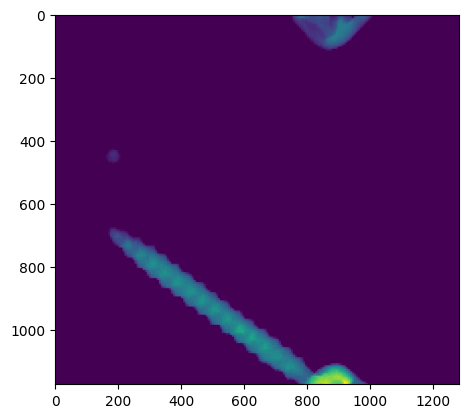

In [6]:
# # # # # Input # # # # #
# Define screw vector
#lineT = rR.axis3D(imD[0], 670, 1100, 'x')  # if starting from screw tip towards head, add (-) to v3
plt.imshow(np.sum(imD[0], axis=1))
del imD
#v3 = -lineT.vector  # z-axis = screw axis, found by function. Specify +/-!!
v3 = -np.array([58, 461, 823]) - np.array([453, 463, 182])
v3 = v3/np.linalg.norm(v3)

In [7]:
# Compute matrix
v2 = np.cross(v3, p1P-p1N)/np.linalg.norm(np.cross(v3, p1P-p1N))  # y-axis
v1 = np.cross(v2, v3)  # x-axis
M = np.vstack((np.append(v1, ori[0]), np.append(v2, ori[1]), np.append(v3, ori[2]), np.array([0, 0, 0, 1])))
print(M)

[[-9.36320719e-01  2.21121222e-01  2.72779978e-01  1.08500000e+03]
 [-2.04580104e-02  7.41157012e-01 -6.71019936e-01  4.52000000e+02]
 [-3.50549542e-01 -6.33870404e-01 -6.89436966e-01  7.05000000e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


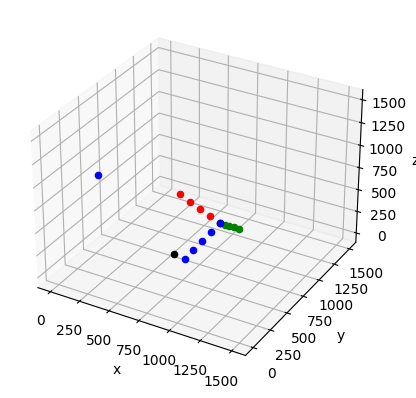

In [8]:
# Check coordinate system
# z-axis (blue) should point from screw head (origin) towards screw tip (dot)
# y-axis (green) should be perpendicular to screw-rotAxis plane and point upwards (against loading direction)
# x-axis (red): right-handed coordinate system
plt.figure()
ax = plt.axes(projection='3d')
fact = 100
for i in range(-0, 5):
    ax.scatter3D(ori[0]+i*fact*v1[0], ori[1]+i*fact*v1[1], ori[2]+i*fact*v1[2], c='r', alpha=1)
    ax.scatter3D(ori[0]+i*fact*v2[0], ori[1]+i*fact*v2[1], ori[2]+i*fact*v2[2], c='g', alpha=1)
    ax.scatter3D(ori[0]+i*fact*v3[0], ori[1]+i*fact*v3[1], ori[2]+i*fact*v3[2], c='b', alpha=1)
ax.scatter3D(p1P[0], p1P[1], p1P[2], c='b')
ax.scatter3D([0, 1500], [0, 1500], [0, 1500], alpha=0)
ax.scatter3D(686, 480, 177, c='k', alpha=1)  # Ti tip
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

In [ ]:
bone = {}
#---bone['SampleName'] = path_ct + file_bone  # File for mapping
stl = path_fea + file_stl
dummyMesh = path_fea + file_dummyMesh
#dummyInp = path_fea + file_dummyInp
bone = test.readInpBoneDummy(bone, dummyMesh)  # Read bone mesh from abaqus. Read elements, nodes
bone = test.boneMeshMask(bone, path_fea, stl, 0.0607, sample + screw + '_mask.mhd')  # Create mask from abaqus bone mesh
mask = test.rR.load_itk(path_fea + sample + screw + '_mask.mhd')

In [ ]:
bone = test.load_BVTVdata(bone, path_ct + file_bone)

In [ ]:
# Read mask
imMask = sitk.ReadImage(path_fea + sample + screw + '_mask.mhd')
imMask_np = np.transpose(sitk.GetArrayFromImage(imMask), [2, 1, 0])
bone["GreyImage"].SetOrigin([0, 0, 0])
# Define rotation and translation
[theta1, theta2, theta3] = rR.rotation_angles_from_matrix(M[:3, :3], 'zyx')
theta2 = -theta2 + np.pi  # +pi because arctan no unique solution. WHY NEGATIVE, because mask[:, ::, :] reshaped?
center = np.array([imMask_np.shape[0]/2, imMask_np.shape[1]/2, 0]) * imMask.GetSpacing()
trans = M[:3, 3] * imMask.GetSpacing() - center

In [ ]:
# Write transformation file
f = open(path_fea + 'transformation_' + sample + screw + '.tfm', "w")
f.write(
    "#Insight Transform File V1.0\n"
    "#Transform 0\n"
    "Transform: CompositeTransform_double_3_3\n"
    "#Transform 1\n"
    "Transform: Euler3DTransform_double_3_3\n"
    "Parameters:  " + f'{theta1}' + " " + f'{theta2}' + " " + f'{theta3}'
    + " " + f'{trans[0]}' + " " + f'{trans[1]}' + " " + f'{trans[2]}' + "\n"  # transformation
    "FixedParameters: " + f'{center[0]}' + " " + f'{center[1]}' + " " + f'{center[2]}' + " 0\n")  # CoR
f.close()

In [ ]:
# Apply transformation to mask using the inverse transformation
bone['Transform'] = sitk.ReadTransform(path_fea + 'transformation_' + sample + screw + '.tfm')
bone['Transform_inv'] = bone['Transform'].GetInverse()
imMask_trans = sitk.Resample(imMask, bone['GreyImage'], bone['Transform_inv'], sitk.sitkNearestNeighbor, 0.0, bone['GreyImage'].GetPixelID())
sitk.WriteImage(imMask_trans, path_fea + sample + screw + '_mask_trans.mhd')
sitk.WriteImage(bone['GreyImage'], path_fea + sample + screw + '_CT.mhd')
del bone['GreyImage']

In [ ]:
# BVTV segmentation / calibration HR-pQCT to uCT
bone['MASK_array_T'] = np.transpose(sitk.GetArrayFromImage(imMask_trans), [2, 1, 0])
# scaling factor/intercept from Schenk et al. 2022, has to be discussed w Ph

In [ ]:
test.HFE_mapping_trans(bone, path_fea + 'elsets.inp', path_fea + 'materials.inp')

In [ ]:
sliceNo = 460
plt.imshow(bone['BVTVscaled'][:, sliceNo, :] + bone['MASK_array_T'][:, sliceNo, :])

In [ ]:
# Write final input file
template = path_fea + '00_' + sample + '_orig.inp'
elsets = path_fea + 'elsets.inp'
materials = path_fea + 'materials.inp'
test.HFE_inp_creator(template, elsets, materials, path_fea + '00_' + sample + screw + '_P', 'PEEK')
test.HFE_inp_creator(template, elsets, materials, path_fea + '00_' + sample + screw + '_T', 'Ti')
# Here switch to Ti does not work yet

In [ ]:
print('Execution time: ' + str(int((time.time()-t1)/60)) + ' min '+ str(round(np.mod(time.time()-t1, 60), 1)) + ' sec.')